## Assign Cluster Labels for PBMC Dataset
1. Initial clustering with Leiden algorithm
2. Combine clusters through KMeans
3. Also construct the resampled PBMC set for dendritic cells.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from numpy.linalg import norm
import scanpy as sc

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
from sklearn.cluster import KMeans

In [93]:
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
output_plots = 'pbmc_plots/ground_truth_plots_step2.pdf'
plot_dictionary = dict()

In [4]:
!pwd

/home/jovyan/work/PBMC_Experiment


In [5]:
!ls

'Assign Labels PBMC Data (Step 2)-Copy1.ipynb'
'Assign Labels PBMC Data (Step 2).ipynb'
'Assign Labels PBMC Data (Step 2)-Old.ipynb'
 cache
 data
'Ignore for Now, Preprocess Simulated PBMC Data (Step 2.1.ipynb'
'PBMC Cluster Measure Sims Part 7.ipynb'
'PBMC Measuring Cluster Performance (Part 4).ipynb'
'PBMC Part 5 Resampling, Preprocessing.ipynb'
'PBMC PC Analysis (Part 3).ipynb'
'PBMC PCA Plot by Ground Truth (Exploratory) Part 8.ipynb'
 pbmc_plots
 pbmc_preprocess.h5ad
 pbmc_sample_preprocess.h5ad
 pca_ground_truth_stats.pdf
 pca_ground_truth_stats_sample.pdf
'PMBC Sim Sample PCA Part 6.ipynb'
'Preprocess PBMC Data (Step 1).ipynb'
 resampled_pbmc_data.csv
 sample_reweighted_ground_truth.csv
 write


In [6]:
adata = sc.read('pbmc_preprocess.h5ad')

In [7]:
adata.X

array([[-0.17146961, -0.2808123 , -0.04667677, ..., -0.09826882,
        -0.20909512, -0.5312033 ],
       [-0.21458235, -0.37265328, -0.05480441, ..., -0.266844  ,
        -0.31314582, -0.5966543 ],
       [-0.3768877 , -0.29508454, -0.05752748, ..., -0.15865593,
        -0.17087644,  1.3789997 ],
       ...,
       [-0.20708963, -0.2504642 , -0.04639699, ..., -0.05114426,
        -0.16106427,  2.041497  ],
       [-0.1903285 , -0.2263338 , -0.04399936, ..., -0.00591774,
        -0.13521305, -0.48211104],
       [-0.33378935, -0.25358772, -0.05271561, ..., -0.07842438,
        -0.13032718, -0.47133783]], dtype=float32)

In [8]:
marker_genes = ['IL7R', 'LYZ', 'CD14', 'MS4A1','CD8A',
                'GNLY', 'NKG7', 'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [9]:
my_data = pd.DataFrame(adata.raw.X.todense(), columns = adata.raw.var['gene_ids'].index.values)

In [10]:
df_marker_genes = my_data[marker_genes]

In [11]:
df_marker_genes = pd.DataFrame(df_marker_genes/df_marker_genes.std())

In [12]:
adata_marker_genes = sc.AnnData(X = df_marker_genes)

Transforming to str index.


In [13]:
sc.pp.neighbors(adata_marker_genes, n_neighbors = 10)

In [14]:
sc.tl.leiden(adata_marker_genes, random_state = 0, resolution = .8)

In [15]:
ground_truth = pd.concat([pd.DataFrame(adata_marker_genes.X, columns = marker_genes),
                          pd.DataFrame(adata_marker_genes.obs['leiden'].values, columns = ['leiden'])], axis = 1)

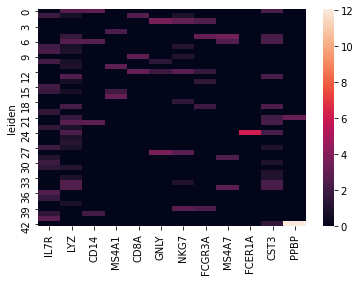

In [16]:
sns.heatmap(ground_truth.groupby('leiden').median())
plot_dictionary['HeatMapLeiden'] = plt.gca().get_figure()

In [17]:
cluster_stats = ground_truth.groupby('leiden').median()

In [26]:
kmeans = KMeans(n_clusters = 12, random_state = 1).fit(cluster_stats.values)

In [27]:
kmeans.labels_

array([ 8,  6,  5,  4,  1,  9,  8,  0,  0,  6,  0,  1,  6,  3,  4,  0,  1,
        1,  4,  3,  0, 10,  8,  0,  7,  4,  4,  0,  5,  0,  0,  0,  4,  4,
        3,  9,  0,  0,  4, 11,  0,  0,  2], dtype=int32)

In [28]:
cluster_stats['new_label'] = kmeans.labels_

In [29]:
new_mapping = dict()
for i in range(len(cluster_stats)):
    new_mapping[cluster_stats.index[i]] = kmeans.labels_[i]

In [30]:
ground_truth['reduced_clustering'] = ground_truth['leiden'].replace(new_mapping)

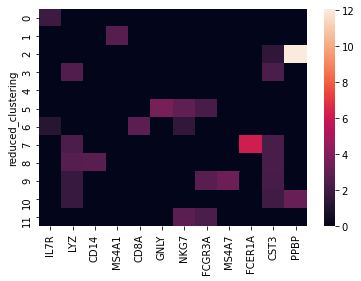

In [31]:
sns.heatmap(ground_truth.groupby('reduced_clustering').median())
plot_dictionary['ReducedHeatMapKMeans'] = plt.gca().get_figure()

1. Cluster 0: CD4 T Cells (IL74)
2. Cluster 1: B Cells (MS4A1)
3. Cluster 2: Megakaryocytes (PPBP)
4. Cluster 3 CD14+ Monocyte (LYZ)
5. Cluster 4: Other
6. Cluster 5: NK Cells (GNLY/NKG7)
7. Cluster 6: CD8 Cells (CD8A)
8. Cluster 7: Dendritic (FCER1A)
9. Cluster 8: CD14+ Monocyte
10. Cluster 9: FCGR3A Monocyte
11. Clusters 10: CD14+ Monocyte
12. Cluster 11: Other

In [32]:
#edit this
cluster_mapping = {0: 'CD4', 1: 'B Cells', 2: 'Megakaryocytes',
                  3: 'CD14+ Monocyte', 4: 'Other', 5: 'NK Cells', 6: 'CD8 Cells',
                  7: 'Dendritic', 8: 'CD14+', 9: 'FCGR3A Monocytes', 10: 'CD14+ Monocyte', 11: 'Other'}

In [33]:
ground_truth['reduced_clustering'].value_counts()

0     701
4     424
1     322
8     298
6     292
3     164
5     159
9     133
10     56
7      55
11     20
2      14
Name: reduced_clustering, dtype: int64

In [34]:
ground_truth['truth_names'] = ground_truth['reduced_clustering'].astype(int).replace(cluster_mapping)

In [37]:
ground_truth['truth_names'].value_counts().reset_index()

,index,truth_names
0,CD4,701
1,Other,444
2,B Cells,322
3,CD14+,298
4,CD8 Cells,292
5,CD14+ Monocyte,220
6,NK Cells,159
7,FCGR3A Monocytes,133
8,Dendritic,55
9,Megakaryocytes,14


In [36]:
ground_truth.head()

,IL7R,LYZ,CD14,MS4A1,CD8A,GNLY,NKG7,FCGR3A,MS4A7,FCER1A,CST3,PPBP,leiden,reduced_clustering,truth_names
0,2.309376,0.861680,0.0,0.000000,2.457721,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,1,6,CD8 Cells
1,1.446049,1.033846,0.0,3.007615,0.000000,0.000000,0.712672,0.000000,0.0000,0.0,0.650767,0.000000,16,1,B Cells
2,1.272185,1.051065,0.0,0.000000,0.000000,1.160852,0.000000,0.000000,0.0000,0.0,0.836933,0.000000,10,0,CD4
3,0.000000,2.381483,0.0,0.000000,0.000000,0.000000,1.004142,1.580884,3.8512,0.0,2.596215,3.067146,21,10,CD14+ Monocyte
4,0.000000,0.000000,0.0,0.000000,0.000000,2.804037,3.031908,0.000000,0.0000,0.0,0.000000,0.000000,28,5,NK Cells


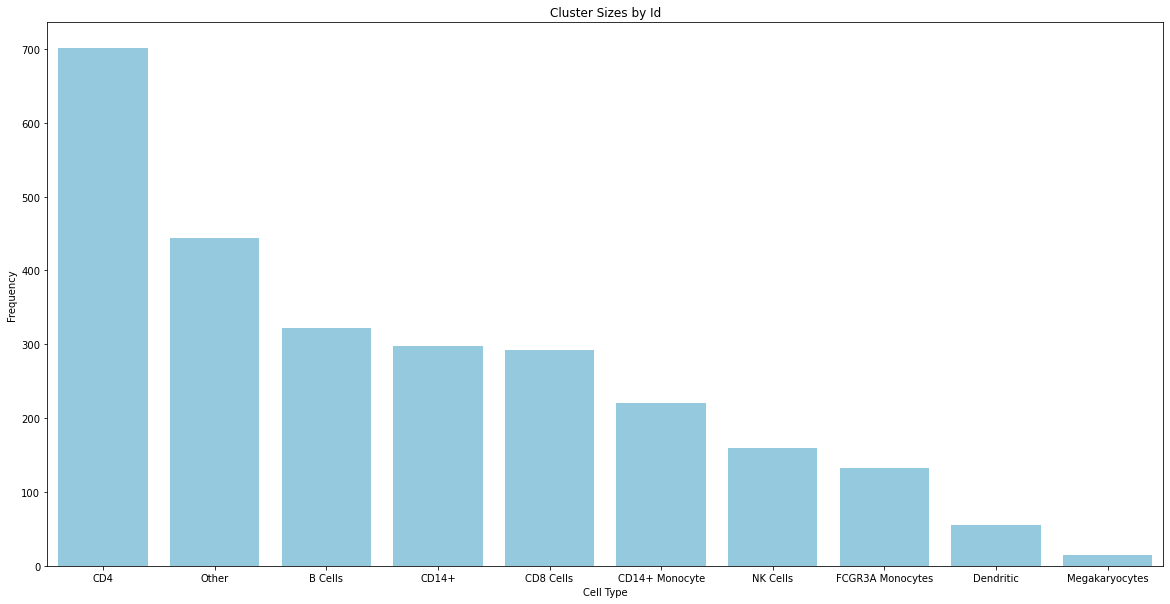

In [40]:
plt.figure(figsize=(20,10))
sns.barplot(x="index", y="truth_names", data=ground_truth['truth_names'].value_counts().reset_index(), 
            color = 'skyblue')
plt.title('Cluster Sizes by Id')
plt.xlabel('Cell Type')
plt.ylabel('Frequency')
plot_dictionary['ClusterSizes'] = plt.gca().get_figure()

In [41]:
ground_truth.to_csv('data/ground_truth_pbmc_v2.csv')

In [150]:
55/2638

0.02084912812736922

### Generate Synthetic Data with Half Dendritic Frequency

In [57]:
my_data = pd.DataFrame(adata.X)

In [58]:
my_data.shape

(2638, 1838)

In [59]:
my_data = pd.concat([my_data, ground_truth[['reduced_clustering','truth_names']]], axis = 1)

In [60]:
my_data.shape

(2638, 1840)

In [61]:
my_data['weights'] = 1
my_data.loc[my_data['truth_names'] == 'Dendritic', 'weights'] = .5
my_data['weights'] = my_data['weights']/np.sum(my_data['weights'])

In [62]:
my_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1831,1832,1833,1834,1835,1836,1837,reduced_clustering,truth_names,weights
0,-0.171470,-0.280812,-0.046677,-0.475169,-0.544024,4.928497,-0.038028,-0.280573,-0.341788,-0.195361,...,-0.222116,-0.312401,-0.121678,-0.521229,-0.098269,-0.209095,-0.531203,6,CD8 Cells,0.000383
1,-0.214582,-0.372653,-0.054804,-0.683391,0.633951,-0.334837,-0.045589,-0.498264,-0.541914,-0.209017,...,-0.445372,1.629285,-0.058662,-0.857163,-0.266844,-0.313146,-0.596654,1,B Cells,0.000383
2,-0.376888,-0.295085,-0.057527,-0.520972,1.332648,-0.309362,-0.103108,-0.272526,-0.500799,-0.220228,...,-0.297857,-0.410920,-0.070431,-0.590720,-0.158656,-0.170876,1.379000,0,CD4,0.000383
3,-0.285241,-0.281735,-0.052227,-0.484929,1.572680,-0.271825,-0.074552,-0.258875,-0.416752,-0.208471,...,-0.247770,2.552079,-0.097402,1.631684,-0.119462,-0.179120,-0.505669,10,CD14+ Monocyte,0.000383
4,-0.256484,-0.220394,-0.046800,-0.345859,-0.333409,-0.208122,-0.069514,5.806440,-0.283112,-0.199355,...,-0.098665,-0.275836,-0.139482,-0.310095,-0.006877,-0.109614,-0.461946,5,NK Cells,0.000383


In [83]:
sim_data = my_data.sample(n = 2638*2, replace = True, weights = my_data['weights'], random_state = 5)

In [84]:
my_data.shape

(2638, 1841)

In [85]:
sim_data.shape

(5276, 1841)

In [86]:
sim_data['truth_names'].value_counts().reset_index()

,index,truth_names
0,CD4,1437
1,Other,925
2,CD14+,631
3,B Cells,603
4,CD8 Cells,580
5,CD14+ Monocyte,442
6,NK Cells,306
7,FCGR3A Monocytes,277
8,Dendritic,54
9,Megakaryocytes,21


In [87]:
dendrites = my_data.loc[my_data['truth_names'] == 'Dendritic']
non_dendrites = my_data.loc[my_data['truth_names'] != 'Dendritic']

In [88]:
dendrites.shape

(55, 1841)

In [89]:
non_dendrites.shape

(2583, 1841)

In [90]:
sim_data.to_csv('data/resampled_pbmc_data_v2.csv')

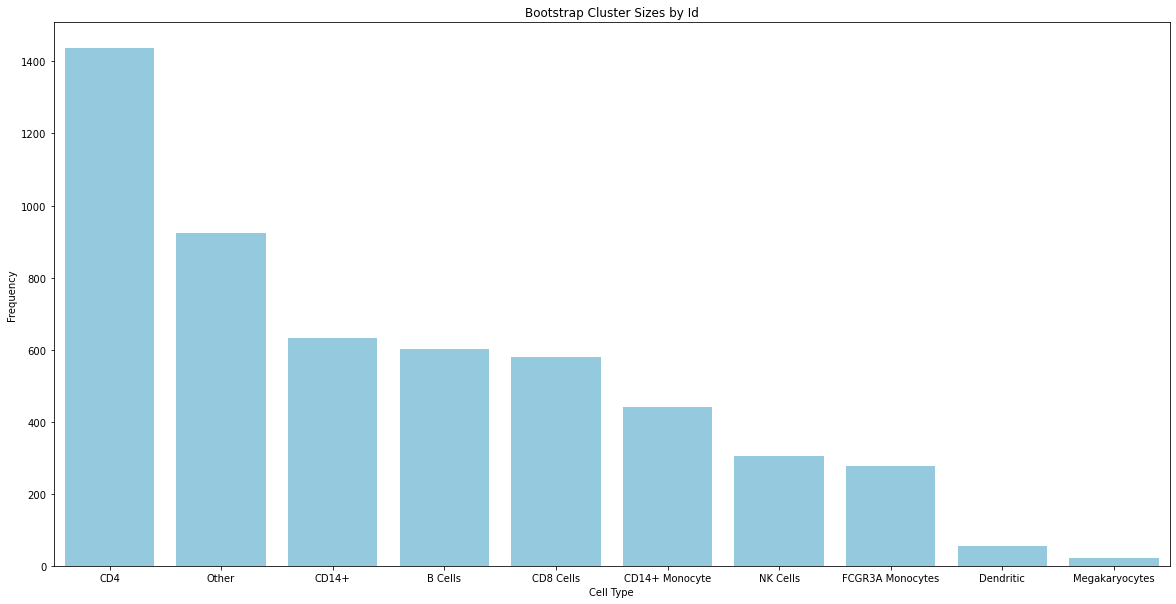

In [91]:
plt.figure(figsize=(20,10))
sns.barplot(x="index", y="truth_names", data=sim_data['truth_names'].value_counts().reset_index(), 
            color = 'skyblue')
plt.title('Bootstrap Cluster Sizes by Id')
plt.xlabel('Cell Type')
plt.ylabel('Frequency')
plot_dictionary['NewSamplingClusterSizes'] = plt.gca().get_figure()

In [94]:
with PdfPages('ground_truth_dist_pbmc.pdf') as pdf:
    for key in plot_dictionary.keys():
        pdf.savefig(plot_dictionary[key])